# 데이터 준비

In [3]:
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import config 
from config import DB_CONFIG
import pymysql  


# MySQL 연결
conn = pymysql.connect(
    host=DB_CONFIG['host'],
    user=DB_CONFIG['user'],
    password=DB_CONFIG['password'],
    database=DB_CONFIG['database'],
    port=DB_CONFIG['port']
)

car_siren = f"SELECT * FROM merge50_car_siren"
car_horn = f"SELECT * FROM merge50_car_horn"
car_driving = f'SELECT * FROM merge50_car_driving'
motorcycle_horn  = f'SELECT * FROM merge50_motorcycle_horn'
motorcycle_driving  = f'SELECT * FROM merge50_motorcycle_driving'

car_siren_df =  pd.read_sql(car_siren, conn)
car_horn_df = pd.read_sql(car_horn, conn) 
car_driving_df = pd.read_sql(car_driving, conn) 
motorcycle_horn_df= pd.read_sql(motorcycle_horn, conn) 
motorcycle_driving_df = pd.read_sql(motorcycle_driving, conn) 

conn.close()

/tmp/ipykernel_25327/3508506696.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  car_siren_df =  pd.read_sql(car_siren, conn)
/tmp/ipykernel_25327/3508506696.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  car_horn_df = pd.read_sql(car_horn, conn)
/tmp/ipykernel_25327/3508506696.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  car_driving_df = pd.read_sql(car_driving, conn)
/tmp/ipykernel_25327/3508506696.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI 

In [4]:
# 데이터 병합
df_combined = pd.concat([car_horn_df, car_siren_df, car_driving_df, motorcycle_horn_df, motorcycle_driving_df], ignore_index=True)

print(f'df_combined 행 개수: {len(df_combined)}')
print(df_combined.columns)


df_combined 행 개수: 16156
Index(['fileName', 'labelName', 'area_start', 'area_end', 'category_01',
       'category_02', 'category_03', 'decibel', 'soundQuality', 'subCategory',
       'bitRate', 'duration', 'fileFormat', 'fileSize', 'recodingType',
       'sampleRate', 'acqDevice', 'acqMethod', 'acqType', 'areaUse',
       'dayNight', 'direction', 'distance', 'district', 'latitude',
       'longitude', 'micClass', 'obstacle', 'place', 'recordingTime', 'urban',
       'weather', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6',
       'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12',
       'mfcc_13'],
      dtype='object')


In [15]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')  # GPU 사용 안 함 (CPU로 실행)

# Softmax 임계값 기반 이상 탐지

In [13]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 데이터 준비
X = df_combined.iloc[:, -13:].values  # MFCC 피처 선택
y = df_combined['category_03'].astype('category').cat.codes  # 라벨 숫자 변환

# 데이터 정규화 (train-test 분할 전에 적용)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 데이터셋 분할 (이제 X_scaled 사용 가능)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 입력 데이터 형태 변경 (Conv1D 사용을 위한 변환)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 원-핫 인코딩 (Softmax 출력을 위해)
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

# CNN 모델 정의
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_train_onehot.shape[1], activation='softmax')  # Softmax 출력
])

# 모델 컴파일 및 훈련
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train_onehot, epochs=50, batch_size=32, validation_data=(X_test, y_test_onehot))

# 예측 및 Softmax 값 확인
y_pred_prob = model.predict(X_test)  # Softmax 확률값 출력
y_pred_max = np.max(y_pred_prob, axis=1)  # 가장 높은 확률값 찾기

# 이상 탐지 기준 [0.7, 0.5(120), 0.4(31), 0.3(1), 0.1(0)]
threshold = 0.4
anomalies = y_pred_max < threshold

# 이상 데이터 개수 확인
print(f"이상 데이터 개수: {np.sum(anomalies)}")

# 이상치로 판별된 샘플의 인덱스 및 카테고리 확인
anomalous_indices = np.where(anomalies)[0]

# y_test를 NumPy 배열로 변환 (Series일 경우 대비)
y_test_array = np.array(y_test)

# 이상 데이터 카테고리 출력
anomalous_categories = y_test_array[anomalous_indices]
print("이상 데이터 카테고리:")
print(anomalous_categories)


Epoch 1/50
404/404 [==============================] - 6s 8ms/step - loss: 0.9319 - accuracy: 0.6414 - val_loss: 1.2160 - val_accuracy: 0.4966
Epoch 2/50
404/404 [==============================] - 3s 7ms/step - loss: 0.6571 - accuracy: 0.7468 - val_loss: 0.4803 - val_accuracy: 0.8110
Epoch 3/50
404/404 [==============================] - 3s 8ms/step - loss: 0.5939 - accuracy: 0.7738 - val_loss: 0.4346 - val_accuracy: 0.8326
Epoch 4/50
404/404 [==============================] - 3s 7ms/step - loss: 0.5622 - accuracy: 0.7842 - val_loss: 0.3888 - val_accuracy: 0.8546
Epoch 5/50
404/404 [==============================] - 3s 8ms/step - loss: 0.5212 - accuracy: 0.8034 - val_loss: 0.3898 - val_accuracy: 0.8586
Epoch 6/50
404/404 [==============================] - 3s 8ms/step - loss: 0.5095 - accuracy: 0.8034 - val_loss: 0.3602 - val_accuracy: 0.8660
Epoch 7/50
404/404 [==============================] - 3s 8ms/step - loss: 0.4844 - accuracy: 0.8126 - val_loss: 0.3777 - val_accuracy: 0.8487
Epoch 

# 이상탐지_Autoencoder

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 레이블(label)과 피처(features) 분리
X = df_combined.iloc[:, -13:]  # 원하는 MFCC 열만 선택
y = df_combined['category_03']  # 차량경적, 차량사이렌

# 범주형 데이터(레이블) 숫자로 변환
y = y.astype('category').cat.codes

# 데이터 정규화
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # X 데이터만 정규화

# 데이터셋 분할 (train: 80%, test: 20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [15]:
# Autoencoder 모델 정의
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation="relu")(input_layer)
encoded = Dense(8, activation="relu")(encoded)

decoded = Dense(16, activation="relu")(encoded)
decoded = Dense(input_dim, activation="sigmoid")(decoded)

autoencoder = Model(input_layer, decoded)

# 모델 컴파일
autoencoder.compile(optimizer='adam', loss='mse')

# 모델 훈련
history = autoencoder.fit(X_train, X_train, 
                          epochs=50, 
                          batch_size=32, 
                          validation_data=(X_test, X_test),
                          verbose=1)

# 예측 및 재구성 오차 계산 (이상 탐지 기준)
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.abs(reconstructions - X_test), axis=1)

# 이상 탐지 임계값 설정 (평균 + 3 표준편차)
threshold = np.mean(mse) + 3 * np.std(mse)

# 이상 데이터 탐지
anomalies = mse > threshold

Epoch 1/50
404/404 [==============================] - 1s 2ms/step - loss: 0.0163 - val_loss: 0.0089
Epoch 2/50
404/404 [==============================] - 1s 2ms/step - loss: 0.0077 - val_loss: 0.0070
Epoch 3/50
404/404 [==============================] - 1s 2ms/step - loss: 0.0063 - val_loss: 0.0059
Epoch 4/50
404/404 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 5/50
404/404 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 6/50
404/404 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 7/50
404/404 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 8/50
404/404 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 9/50
404/404 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 10/50
404/404 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0041

/home/ubuntu/anaconda3/envs/ml_env_python3.6/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/anaconda3/envs/ml_env_python3.6/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/anaconda3/envs/ml_env_python3.6/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 53456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/anaconda3/envs/ml_env_python3.6/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51648 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/anaconda3/envs/ml_env_python3.6/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47484 missing from current font.
  font.set_t

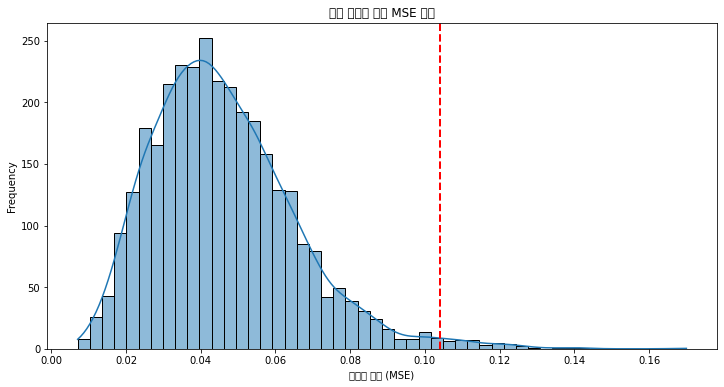

이상 데이터 개수: 42


In [17]:
# 시각화
plt.figure(figsize=(12, 6))
sns.histplot(mse, bins=50, kde=True)
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2)
plt.xlabel("재구성 오차 (MSE)")
plt.ylabel("Frequency")
plt.title("이상 탐지를 위한 MSE 분포")
plt.show()

print(f"이상 데이터 개수: {np.sum(anomalies)}")

In [18]:
# 이상 데이터를 가진 인덱스 찾기
anomalous_indices = np.where(anomalies)[0]

# 이상 데이터를 확인하기 위해 해당 인덱스의 라벨과 카테고리 확인
anomalous_labels = y.iloc[anomalous_indices]  # 레이블
anomalous_categories = df_combined.iloc[anomalous_indices]['category_03']  # 카테고리

# 출력: 이상 데이터의 라벨과 카테고리
print(f"이상 데이터 개수: {len(anomalous_indices)}")
print("이상 데이터 라벨:")
print(anomalous_labels)
print("이상 데이터 카테고리:")
print(anomalous_categories)


이상 데이터 개수: 42
이상 데이터 라벨:
60      2
97      2
387     2
446     2
908     2
937     2
1051    2
1074    2
1098    2
1105    2
1107    2
1132    2
1290    2
1413    2
1635    2
1640    2
1720    2
1740    2
1831    2
1842    2
1854    2
1898    2
1939    2
1944    2
2033    2
2037    2
2145    2
2180    2
2247    2
2345    2
2439    2
2446    2
2502    2
2633    2
2744    2
2884    2
2907    2
2939    2
3127    2
3188    2
3212    3
3218    3
dtype: int8
이상 데이터 카테고리:
60       차량경적
97       차량경적
387      차량경적
446      차량경적
908      차량경적
937      차량경적
1051     차량경적
1074     차량경적
1098     차량경적
1105     차량경적
1107     차량경적
1132     차량경적
1290     차량경적
1413     차량경적
1635     차량경적
1640     차량경적
1720     차량경적
1740     차량경적
1831     차량경적
1842     차량경적
1854     차량경적
1898     차량경적
1939     차량경적
1944     차량경적
2033     차량경적
2037     차량경적
2145     차량경적
2180     차량경적
2247     차량경적
2345     차량경적
2439     차량경적
2446     차량경적
2502     차량경적
2633     차량경적
2744     차량경적
2884     차량경적
2907     차량경적
2939     차량경